In [35]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as reader
from dateutil.relativedelta import relativedelta
import numpy as np
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
#import data
esg_use = pd.read_csv("esg_use.csv")
esg_use = esg_use.rename(columns={"symbol_x": "Tickers"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [37]:

def esgstrategies(data):
    #Part1. Determining portfolio stocks
    use1 = data.groupby(['Tickers', 'industry']).mean()
    use3 = use1.dropna().reset_index()
    #Determine top 30 average ESG_Mean score stocks from each industry company
    use3["rank"] = use3.groupby("industry")["ESG_Mean"].rank(method="dense", ascending=False)
    selection = use3[use3['rank'] <= 30]
    Tickers = selection.Tickers.to_list()
    #Calculate 1 year momentum of ESG_STS Mean of ranked stocks
    use2 = data[data['Tickers'].isin(Tickers)]
    use2['mom'] = use2['ESG_STS_Mean'].pct_change(12)
    use4 = use2.groupby(['Tickers', 'industry']).mean()
    use5 = use4.dropna().reset_index()
    final_table = use5.reset_index()
    #select top 5 stocks with highest momentum of ESG_STS mean
    final_table["rank"] = final_table.groupby("industry")["ESG_STS_Mean"].rank(method="dense", ascending=False)
    selection1 = final_table[final_table['rank'] <= 5]
    ticker = selection1.Tickers.to_list()
    df = reader.get_data_yahoo(ticker, start, end)['Adj Close']
    #Sharpe Ratio
    timeperiod = 30
    for i in ticker:
        df[i + 'ret'] = 100*(df[i]/df[i].shift(timeperiod)-1)
    for i in ticker:
        df[i + 'std'] = df[i + 'ret'].rolling(timeperiod).std()
    for i in ticker:
        df[i + 'sharpe'] = df[i + 'ret'] / df[i + 'std']
    start_s, end_s = len(ticker), 4*len(ticker)
    sharpe = df.iloc[:, start_s:end_s]
    print(sharpe.describe())
    
    
    
    
    #Part two Apply constructed portfolio to Momentum trading strategies
    
    
    
    
    mtl_ret = df.pct_change().resample('M').agg(lambda x: (x+1).prod()-1)
    past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1
    formation = dt.datetime(2019,12,31)
    end_measurement = formation - relativedelta(months=1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_13 = ret_12.iloc[0:35]
    ret_13['quintile'] = pd.qcut(ret_13.iloc[:,1], 5, labels=False)
    winners = ret_13[ret_13.quintile==4]
    losers = ret_13[ret_13.quintile == 0]
    winnerret = mtl_ret.loc[formation+relativedelta(months=1), df.columns.isin(winners.Symbols)]
    loserret = mtl_ret.loc[formation+relativedelta(months=1), df.columns.isin(losers.Symbols)]
    Momentumprofit = winnerret.mean() - loserret.mean()
    return Momentumprofit

In [38]:
return1 = esgstrategies(esg_use)

<ipython-input-37-a35d4e93f63c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use2['mom'] = use2['ESG_STS_Mean'].pct_change(12)
/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '0765', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '124', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '1775', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/

Symbols  0765ret  124ret  1775ret  3782ret  40Eret  601ret  8158ret  8228ret  \
count        0.0     0.0      0.0      0.0     0.0     0.0      0.0      0.0   
mean         NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
std          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
min          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
25%          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
50%          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
75%          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   
max          NaN     NaN      NaN      NaN     NaN     NaN      NaN      NaN   

Symbols  8603ret  9533ret  AAP.Hret     ABVGret     ADTRret  AFGBret  AGJret  \
count        0.0      0.0       0.0  474.000000  474.000000      0.0     0.0   
mean         NaN      NaN       NaN   -2.004219   -4.113399      NaN     NaN   
std          NaN      NaN       NaN   2

<ipython-input-37-a35d4e93f63c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret_13['quintile'] = pd.qcut(ret_13.iloc[:,1], 5, labels=False)


In [39]:
return1

0.26964620888167573

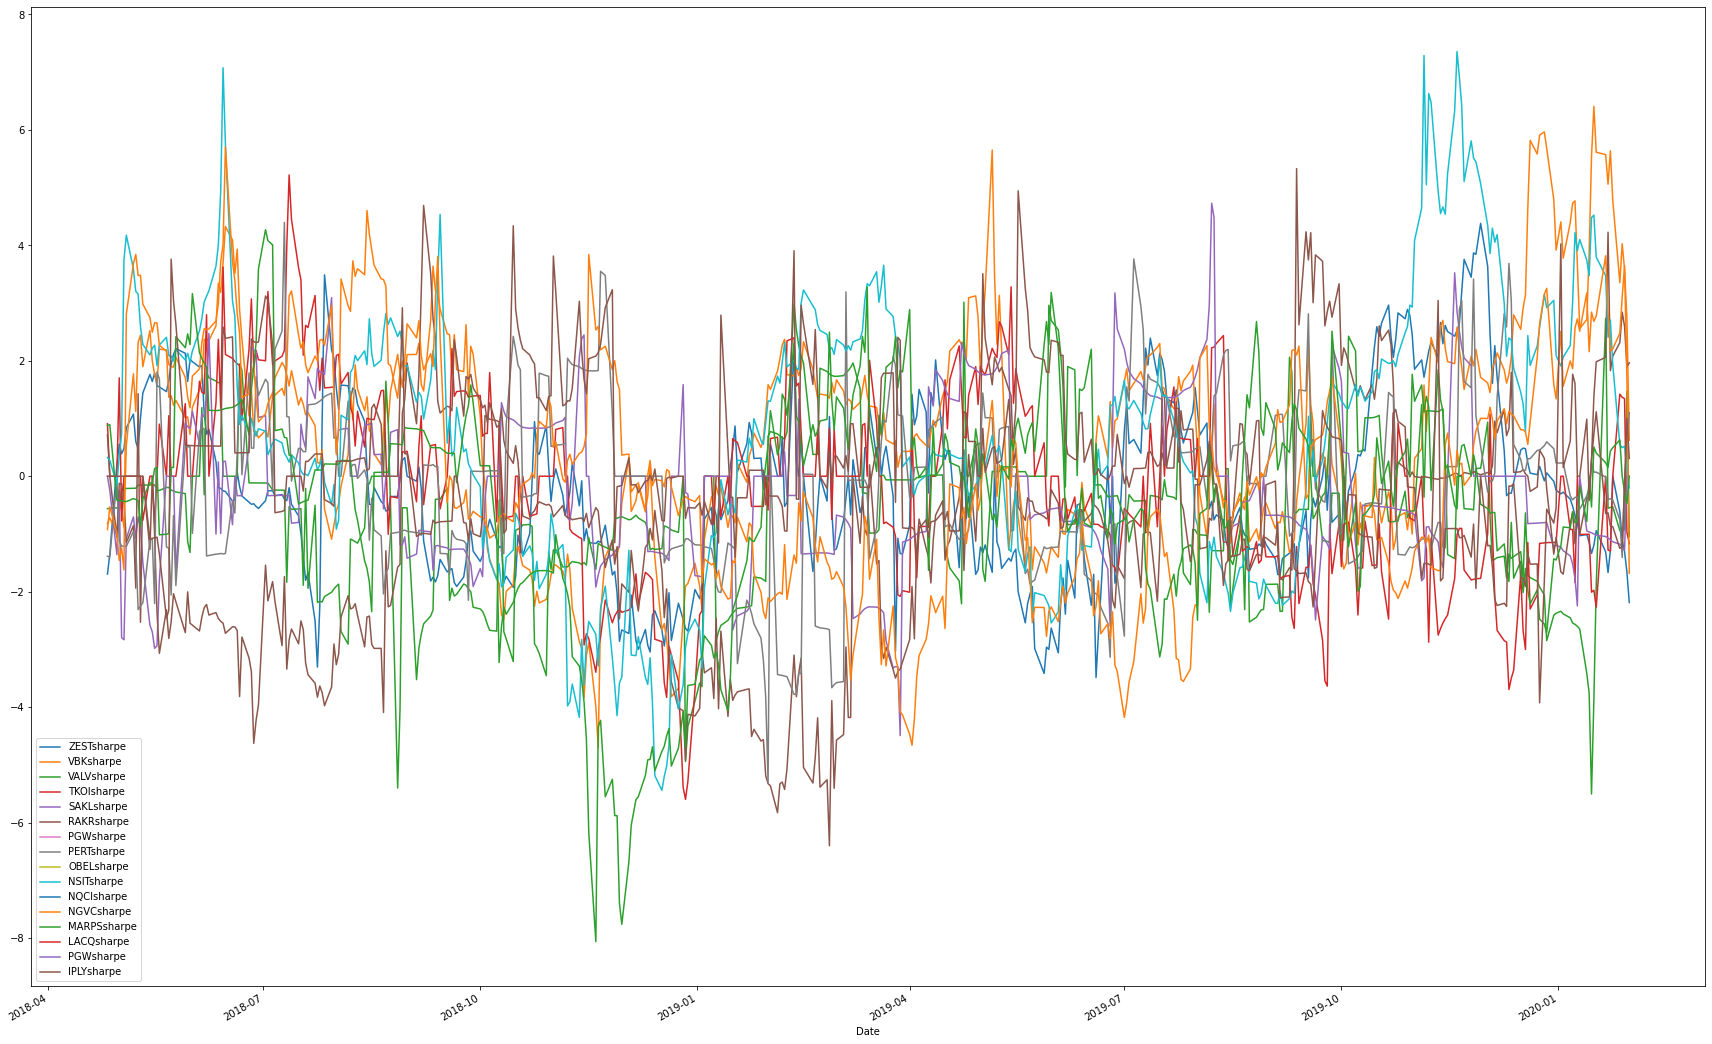

In [29]:
#Plotting sharpe ratio 
import matplotlib.pyplot as plt
sharpe['ZESTsharpe'].plot(label='ZESTsharpe', figsize=(30, 20))
sharpe['VBKsharpe'].plot(label= 'VBKsharpe', figsize=(30, 20))
sharpe['VALVsharpe'].plot(label='VALVsharpe', figsize=(30, 20))
sharpe['TKOIsharpe'].plot(label= 'TKOIsharpe', figsize=(30, 20))
sharpe['SAKLsharpe'].plot(label='SAKLsharpe', figsize=(30, 20))
sharpe['RAKRsharpe'].plot(label= 'RAKRsharpe', figsize=(30, 20))
sharpe['PGWsharpe'].plot(label='PGWsharpe', figsize=(30, 20))
sharpe['PERTsharpe'].plot(label= 'PERTsharpe', figsize=(30, 20))
sharpe['OBELsharpe'].plot(label='OBELsharpe', figsize=(30, 20))
sharpe['NSITsharpe'].plot(label= 'NSITsharpe', figsize=(30, 20))
sharpe['NQCIsharpe'].plot(label='NQCIsharpe', figsize=(30, 20))
sharpe['NGVCsharpe'].plot(label= 'NGVCsharpe', figsize=(30, 20))
sharpe['MARPSsharpe'].plot(label='MARPSsharpe', figsize=(30, 20))
sharpe['LACQsharpe'].plot(label= 'LACQsharpe', figsize=(30, 20))
sharpe['PGWsharpe'].plot(label='PGWsharpe', figsize=(30, 20))
sharpe['IPLYsharpe'].plot(label= 'IPLYsharpe', figsize=(30, 20))

plt.legend()
    